# 注意力评分函数
:label:`sec_attention-scoring-functions`

在 :numref:`sec_nadaraya-waston` 中，我们使用高斯核来对查询和键之间的关系建模。可以将 :eqref:`eq_nadaraya-waston-gaussian` 中的高斯核的指数部分视为 *注意力评分函数*（attention scoring function），简称 *评分函数*（scoring function），然后把这个函数的输出结果输入到 softmax 函数中进行运算。通过上述步骤，我们将得到与键对应的值的概率分布（即注意力权重）。最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，可以使用上述算法来实现 :numref:`fig_qkv` 中的注意力机制框架。:numref:`fig_attention_output` 说明了如何将注意力汇聚的输出计算成为值的加权和，其中 $a$ 表示注意力评分函数。由于注意力权重是概率分布，因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和。](../img/attention-output.svg)
:label:`fig_attention_output`

用数学语言描述，假设有一个查询 $\mathbf{q} \in \mathbb{R}^q$ 和 $m$ 个“键－值”对 $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，其中 $\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。注意力汇聚函数 $f$ 就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询 $\mathbf{q}$ 和键 $\mathbf{k}_i$ 的注意力权重（标量）是通过注意力评分函数 $a$ 将两个向量映射成标量，再经过 softmax 运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如我们所看到的，选择不同的注意力评分函数 $a$ 会导致不同的注意力汇聚操作。在本节中，我们将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。


In [1]:
import math
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()


## [**遮蔽softmax操作**]

正如上面提到的，softmax 运算用于输出一个概率分布作为注意力权重。在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。例如，为了在 :numref:`sec_machine_translation` 中高效处理小批量数据集，某些文本序列被填充了没有意义的特殊词元。为了仅将有意义的词元作为值去获取注意力汇聚，可以指定一个有效序列长度（即词元的个数），以便在计算 softmax 时过滤掉超出指定范围的位置。通过这种方式，我们可以在下面的 `masked_softmax` 函数中实现这样的 *遮蔽 softmax 操作*（masked softmax operation），其中任何超出有效长度的位置都被遮蔽并置为0。


In [2]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作"""
    # `X`: 3D张量, `valid_lens`: 1D或2D 张量
    if valid_lens is None:
        return npx.softmax(X)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = valid_lens.repeat(shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 在最后的轴上，被遮蔽的元素使用一个非常大的负值替换，从而其 softmax (指数)输出为 0
        X = npx.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, True,
                              value=-1e6, axis=1)
        return npx.softmax(X).reshape(shape)

为了[**演示此函数是如何工作**]的，考虑由两个 $2 \times 4$ 矩阵表示的样本，这两个样本的有效长度分别为 $2$ 和 $3$。经过遮蔽 softmax 操作，超出有效长度的值都被遮蔽为0。


In [3]:
masked_softmax(np.random.uniform(size=(2, 2, 4)), np.array([2, 3]))

array([[[0.488994  , 0.511006  , 0.        , 0.        ],
        [0.4365484 , 0.56345165, 0.        , 0.        ]],

       [[0.288171  , 0.3519408 , 0.3598882 , 0.        ],
        [0.29034296, 0.25239873, 0.45725837, 0.        ]]])

同样，我们也可以使用二维张量为矩阵样本中的每一行指定有效长度。


In [4]:
masked_softmax(np.random.uniform(size=(2, 2, 4)),
               np.array([[1, 3], [2, 4]]))

array([[[1.        , 0.        , 0.        , 0.        ],
        [0.35848376, 0.3658879 , 0.27562833, 0.        ]],

       [[0.54370314, 0.45629686, 0.        , 0.        ],
        [0.19598778, 0.25580427, 0.19916739, 0.3490406 ]]])

## [**加性注意力**]
:label:`subsec_additive-attention`

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。给定查询 $\mathbf{q} \in \mathbb{R}^q$ 和键 $\mathbf{k} \in \mathbb{R}^k$，*加性注意力*（additive attention） 的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

其中可学习的参数是 $\mathbf W_q\in\mathbb R^{h\times q}$、$\mathbf W_k\in\mathbb R^{h\times k}$ 和 $\mathbf w_v\in\mathbb R^{h}$。如 :eqref:`eq_additive-attn` 所示，将查询和键连接起来后输入到一个多层感知机（MLP）中，感知机包含一个隐藏层，其隐藏单元数是一个超参数 $h$。通过使用 $\tanh$ 作为激活函数，并且禁用偏置项，我们将在下面实现加性注意力。


In [5]:
#@save
class AdditiveAttention(nn.Block):
    """加性注意力"""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # 使用 'flatten=False' 只转换最后一个轴，以便其他轴的形状保持不变
        self.W_k = nn.Dense(num_hiddens, use_bias=False, flatten=False)
        self.W_q = nn.Dense(num_hiddens, use_bias=False, flatten=False)
        self.w_v = nn.Dense(1, use_bias=False, flatten=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # `queries` 的形状：(`batch_size`, 查询的个数, 1, `num_hidden`)
        # `key` 的形状：(`batch_size`, 1, “键－值”对的个数, `num_hiddens`)
        # 使用广播的方式进行求和
        features = np.expand_dims(queries, axis=2) + np.expand_dims(keys, axis=1)
        features = np.tanh(features)
        # `self.w_v` 仅有一个输出，因此从形状中移除最后那个维度。
        # `scores` 的形状：(`batch_size`, 查询的个数, “键-值”对的个数)
        scores = np.squeeze(self.w_v(features), axis=-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # `values` 的形状：(`batch_size`, “键－值”对的个数, 值的维度)
        return npx.batch_dot(self.dropout(self.attention_weights), values)

让我们用一个小例子来[**演示上面的`AdditiveAttention`类**]，其中查询、键和值的形状为（批量大小、步数或词元序列长度、特征大小），实际输出为 $(2,1,20)$、$(2,10,2)$ 和 $(2,10,4)$。注意力汇聚输出的形状为（批量大小、查询的步数、值的维度）。


In [6]:
queries, keys = np.random.normal(0, 1, (2, 1, 20)), np.ones((2, 10, 2))
# `values` 的小批量数据集中，两个值矩阵是相同的
values = np.arange(40).reshape(1, 10, 4).repeat(2, axis=0)
valid_lens = np.array([2, 6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.initialize()
attention(queries, keys, values, valid_lens)

array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]])

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，所以[**注意力权重**]是均匀的，由指定的有效长度决定。


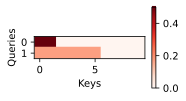

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数。但是点积操作要求查询和键具有相同的长度 $d$。假设查询和键的所有元素都是独立的随机变量，并且都满足均值为 $0$ 和方差为 $1$。那么两个向量的点积的均值为 $0$，方差为 $d$。为确保无论向量长度如何，点积的方差在不考虑向量长度的情况下仍然是 $1$，则可以使用 *缩放点积注意力*（scaled dot-product attention） 评分函数：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$$

将点积除以 $\sqrt{d}$。在实践中，我们通常从小批量的角度来考虑提高效率，例如基于 $n$ 个查询和 $m$ 个键－值对计算注意力，其中查询和键的长度为 $d$，值的长度为 $v$。查询 $\mathbf Q\in\mathbb R^{n\times d}$、键 $\mathbf K\in\mathbb R^{m\times d}$ 和值 $\mathbf V\in\mathbb R^{m\times v}$ 的缩放点积注意力是

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

在下面的缩放点积注意力的实现中，我们使用了 dropout 进行模型正则化。


In [8]:
#@save
class DotProductAttention(nn.Block):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `queries` 的形状：(`batch_size`, 查询的个数, `d`)
    # `keys` 的形状：(`batch_size`, “键－值”对的个数, `d`)
    # `values` 的形状：(`batch_size`, “键－值”对的个数, 值的维度)
    # `valid_lens` 的形状: (`batch_size`,) 或者 (`batch_size`, 查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置 `transpose_b=True` 为了交换 `keys` 的最后两个维度
        scores = npx.batch_dot(queries, keys, transpose_b=True) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return npx.batch_dot(self.dropout(self.attention_weights), values)

为了[**演示上述的`DotProductAttention`类**]，我们使用了与先前加性注意力例子中相同的键、值和有效长度。对于点积操作，令查询的特征维度与键的特征维度大小相同。


In [9]:
queries = np.random.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.initialize()
attention(queries, keys, values, valid_lens)

array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]])

与加性注意力演示相同，由于键包含的是相同的元素，而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


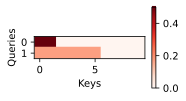

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 小结

* 可以将注意力汇聚的输出计算作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。

## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？
1. 只使用矩阵乘法，您能否为具有不同矢量长度的查询和键设计新的评分函数？
1. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？


[Discussions](https://discuss.d2l.ai/t/346)
